## 1. Early Stop + Learning Rate Decay + LR Visualization

In [ ]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
# Load MNIST dataset by mnist.npz
import numpy as np
# mnist = np.load('data/mnist.npz')  # [i for i in mnist.keys()]
# print("mnist keys: ", [i for i in mnist.keys()])  # ['x_test', 'x_train', 'y_train', 'y_test']
with np.load('data/mnist.npz') as data:
    train_examples = data['x_train']  # shape = (60000, 28, 28)
    train_labels = data['y_train']  # shape = (60000, )
    test_examples = data['x_test']  # shape = (10000, 28, 28)
    test_labels = data['y_test']  # shape = (10000, )

In [4]:
# 데이터셋이 0-1 사이의 값인지 / 0-255 사이의 값인지 확인
np.histogram(train_examples)

(array([38847859,   571880,   514157,   438029,   446644,   503214,
          469607,   518723,   611860,  4118027]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]))

In [5]:
# MNIST Normalization
mnist_mean = train_examples.mean()
mnist_std = train_examples.std()
print("mean: {}, std: {}".format(mnist_mean, mnist_std))

mean: 33.318421449829934, std: 78.56748998339798


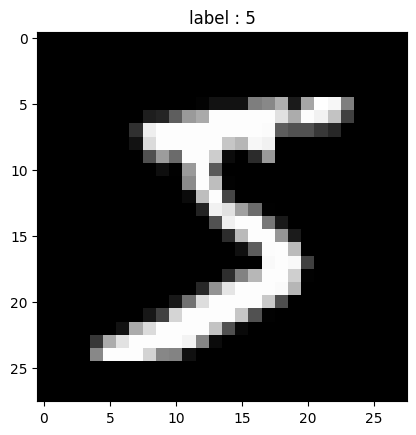

In [6]:
# Visualize MNIST sample
plt.imshow(train_examples[0], cmap='gray')
plt.title('label : %s' % train_labels[0])
plt.show()

In [34]:
# Configs
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
DROPOUT_RATE = 0.2
EPOCHS = 10
PATIENCE = 1  # 몇번의 epoch동안 loss가 떨어지지 않으면 lr decay?

In [35]:
# Pytorch Dataset
from torch.utils.data import Dataset


class MnistDataset(Dataset):
    def __init__(self, images, labels, transform=None, target_transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = Image.fromarray(image)

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [36]:
# Train MNIST dataset

train_transform = transforms.Compose([
    # transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mnist_mean], std=[mnist_std]),

    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mnist_mean], std=[mnist_std]),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

train_dataset = MnistDataset(train_examples, train_labels, transform=train_transform)
test_dataset = MnistDataset(test_examples, test_labels, transform=test_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=1, shuffle=False, num_workers=2)

In [37]:
class MnistClassifier(torch.nn.Module):
    def __init__(self, input_size=(28, 28), num_classes=10, dropout_late=0.2):
        super(MnistClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding='same')  # 28 28
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool2d = nn.MaxPool2d((2, 2))  #
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3, 1, padding='same')
        self.bn3 = nn.BatchNorm2d(64)  # 원본: 128
        self.fc1 = nn.Linear(7*7*64, 64)  # 원본: 7*7*128
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout2d(dropout_late)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.maxpool2d(self.relu(self.bn1(self.conv1(x))))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.maxpool2d(self.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.nn.functional.log_softmax(x, dim=1)
        return x

# Learning Rate Decay + LR decay

In [40]:
model = MnistClassifier(dropout_late=DROPOUT_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 8], gamma=0.1)

In [41]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [42]:
train_loss_list = []
train_lr_list = []
test_loss_list = []

patience_check = 0
best_loss = 10000

for epoch in range(EPOCHS):
    train_loss = 0.
    test_loss = 0.
    train_lr_list.append(get_lr(optimizer))
    model.train()
    for i, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print("Epoch {}/{} || Train Loss : {:3f}".format(epoch, EPOCHS, train_loss/len(train_loader)))
    scheduler.step()
    model.eval()

    count = 0
    for i, (image, label) in enumerate(test_loader):
        pred = model(image)
        loss = criterion(pred, label)
        test_loss += loss.item()

        if pred.argmax().item() == label.item():
            count += 1

    test_loss = test_loss/len(test_loader)

    # Early Stop
    if test_loss > best_loss:
        patience_check += 1
        if patience_check >= PATIENCE:
            break
    else:
        best_loss = test_loss
        patience_check = 0

    print("Epoch {}/{} || Test Loss : {:3f}".format(epoch, EPOCHS, test_loss))
    print("Test Accuracy : {:3f}".format(count / len(test_loader)))


Epoch 0/10 || Train Loss : 0.694447
Epoch 0/10 || Test Loss : 0.243341
Test Accuracy : 0.925000
Epoch 1/10 || Train Loss : 0.225049
Epoch 1/10 || Test Loss : 0.163315
Test Accuracy : 0.952000
Epoch 2/10 || Train Loss : 0.161165
Epoch 2/10 || Test Loss : 0.115740
Test Accuracy : 0.964000
Epoch 3/10 || Train Loss : 0.129196
Epoch 3/10 || Test Loss : 0.102324
Test Accuracy : 0.967800
Epoch 4/10 || Train Loss : 0.113108
Epoch 4/10 || Test Loss : 0.090323
Test Accuracy : 0.971800
Epoch 5/10 || Train Loss : 0.088132
Epoch 5/10 || Test Loss : 0.071771
Test Accuracy : 0.977200
Epoch 6/10 || Train Loss : 0.084735


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(train_lr_list)), train_lr_list, color='blue')

plt.ylabel('Learning rate')
plt.xlabel('epoch');